In [1]:
library(ggplot2)
library(scales)
library(vcfR)
library("tidyverse")
library(gridExtra)
library(ggridges)
library(cowplot)
theme_set(theme_minimal())


   *****       ***   vcfR   ***       *****
   This is vcfR 1.12.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.3     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
asinh_trans <- function(){
  trans_new(name = 'asinh', transform = function(x) asinh(x), 
            inverse = function(x) sinh(x))
}
     
read_vcf <- function(vcf_file) {
    vcf <- read.vcfR( vcf_file, verbose = FALSE )  
    values = vcfR2tidy(vcf, 
          info_only = TRUE,
          info_fields = c("SVLEN", "IDLIST"),
          verbose = FALSE)  
    values$fix = values$fix %>% mutate(SVLEN=as.integer(SVLEN))
    return(values)
}
       
read_jasmine_techno <- function(df, techno, toolid, min=-500000, max=500000, svlenmin=50) {
     technosv = df$fix %>% 
                    filter(FILTER=="PASS") %>%
                    filter(str_detect(IDLIST, toolid)) %>%
                    filter(SVLEN>=min & SVLEN<=max) %>%
                    filter(abs(SVLEN)>=svlenmin) %>%
                    filter(!str_detect(CHROM, "NKL"))
     technodata = data.frame(as.numeric(technosv$SVLEN))
     names(technodata) = "size"
     technodata$techno = techno
     technodata$techno = as.factor(technodata$techno)
     return(technodata)
}

readsizes_from_vcf <- function(vcf_file, min, max) {
    vcf <- read.vcfR( vcf_file, verbose = FALSE )  
    values = vcfR2tidy(vcf, 
          single_frame = TRUE, 
          info_fields = c("SVLEN"),
          verbose = FALSE)
    values$dat = values$dat %>% mutate(SVLEN=as.integer(SVLEN))
    values$dat = values$dat %>% filter(SVLEN>=min & SVLEN<=max)
    return(as.numeric(values$dat$SVLEN))
}  
            
read_techno <- function(techno, techno_vcf, min=-500000, max=500000) {
    size = readsizes_from_vcf(techno_vcf, min, max)
    technodata = data.frame(size)
    technodata$techno=techno
    technodata$techno = as.factor(technodata$techno)
    return(technodata)
}             
                
                        
dualplotmulti <- function(data, adjust=4) {
   negative = subset(data, size<0, select=c(size, techno))
   p1 = ggplot() +
               geom_density(data = negative, aes(x=size, y=..count.., color=techno), adjust=adjust, alpha=0.3, bw=0.02, fill=NA) +
               #coord_cartesian(ylim=c(0,New x label 10000)) +
               theme_bw() +
               scale_x_continuous(limits=c(-100000,-50), 
                                  breaks=c(-100000,-10000,-100, -50),
                                  label=c('-100kb','-10kb','-100bp',''),
                                  trans="asinh",
                                  expand = expansion(add = 0.1)) + 
               theme(plot.margin = unit(c(1,0,1,1), "cm")) +
               #scale_y_continuous(position = "left",  breaks=c(5000,10000), labels=c(200, 400)) + 
               theme(legend.position = "none") + 
               labs(x = "Deletions")
   positive = subset(data, size>0, select=c(size, techno))
   p2 = ggplot() +
            geom_density(data = positive, aes(x=size, y=..count.., color=techno), adjust=adjust, alpha=0.3, bw=0.02, fill=NA) +
            #coord_cartesian(ylim=c(0, 10000)) +
            theme_bw() +
            scale_x_continuous(limits=c(50,100000), 
                                breaks=c(50, 100, 10000, 100000),
                                label=c('', '100bp','10kb','100kb'),
                                trans="asinh",
                                expand = expansion(add = 0.1)) + 
            theme(plot.margin = unit(c(1,1,1,0), "cm"))  +
            #guides(colour = guide_legend(override.aes = list(alpha = 1)))
            scale_y_continuous(position = "right",  breaks=c(5000,10000), labels=c(200, 400)) +
            labs(x = "Insertions")
    return(list("left"=p1, "right"=p2))
}
            

plotmulti <- function(data, adjust=4) {
    data$abs_size = abs(data$size)
    p = ggplot() +
            geom_density(data = data, aes(x=size, y=..count.., color=techno), adjust=adjust, alpha=0.3, bw=0.02, fill=NA) +
            theme_bw() +
            scale_x_continuous(limits=c(50,100000), 
                                breaks=c(50, 100, 10000, 100000),
                                label=c('', '100bp','10kb','100kb'),
                                trans="asinh",
                                expand = expansion(add = 0.1)) + 
            theme(plot.margin = unit(c(1,1,1,0), "cm"))  +
            scale_y_continuous(position = "right",  breaks=c(5000,10000), labels=c(200, 400)) +
            geom_vline(xintercept = 144) +
            geom_vline(xintercept = 284) +
            geom_vline(xintercept = 1300) +
            geom_vline(xintercept = 8500) +
            annotate("text", x=144, y=-700, label="144",
              color="black") +
            annotate("text", x=284, y=-700, label="284",
              color="black") +
            annotate("text", x=1300, y=-700, label="1300",
              color="black") +
            annotate("text", x=8500, y=-700, label="8500",
              color="black") +
            coord_cartesian(ylim = c(-10, 10000), clip = "off")
    return(p)
}

In [3]:
vcffile="jasmine_options_Full_DELINS_sort.vcf.gz"
df = read_vcf(vcffile)

In [4]:
illumina = read_jasmine_techno(df, "illumina", "Manta")
CLR = read_jasmine_techno(df, "CLR", "CLR")
HiFi = read_jasmine_techno(df, "HiFi", "HiFi")
ONT = read_jasmine_techno(df, "ONT", "svim")
assembly = read_jasmine_techno(df, "assembly", "paftools")
bionano = read_techno("bionano", "Bta_G2_vs_Ref_DELINS_sorted.vcf.gz")
data = rbind(HiFi, CLR, ONT, illumina, assembly, bionano)
summary(data)

      size                techno     
 Min.   :-490062.0   HiFi    :22417  
 1st Qu.:   -209.0   CLR     :22195  
 Median :    -54.0   ONT     :22108  
 Mean   :   -405.7   illumina:14375  
 3rd Qu.:    161.0   assembly:10109  
 Max.   : 499811.0   bionano : 3818  

Warning message:
“Removed 76 rows containing non-finite values (stat_density).”
Warning message:
“Removed 28 rows containing non-finite values (stat_density).”


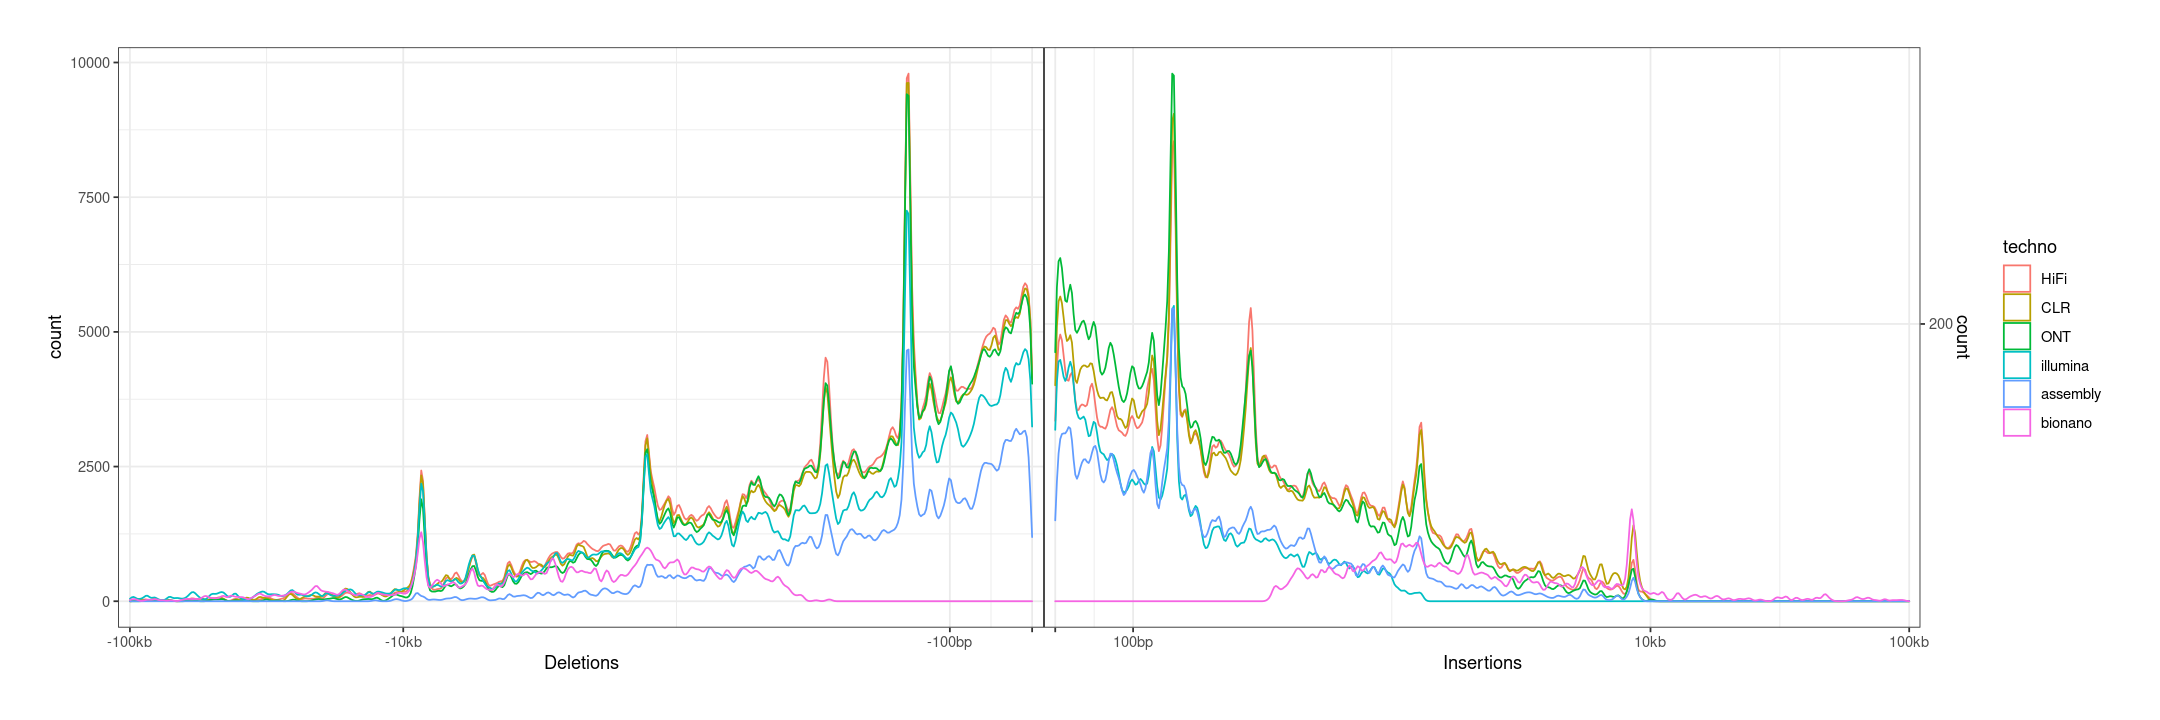

In [5]:
g = dualplotmulti(data, adjust=1)
options(repr.plot.width = 18, repr.plot.height = 6)
plot_grid(g$left, g$right, align = "h", ncol = 2, rel_widths = c(29/60, 31/60))
#grid.arrange(g$left, g$right, ncol=2, top = "Size distribution")

In [ ]:
plotmulti(data, adjust=1)

### Total inserted sequence

In [ ]:
insertions = HiFi %>% filter(size>0)
sum(insertions["size"])

In [ ]:
large_insertions = HiFi %>% filter(size>300)
sum(large_insertions["size"])

In [ ]:
deletions = HiFi %>% filter(size<0 && size>-200000)
sum(deletions["size"])

In [ ]:
data = rbind(CLR, illumina)
summary(data)

In [ ]:
g = dualplotmulti(data, adjust=2)
options(repr.plot.width = 16, repr.plot.height = 6)
grid.arrange(g$left, g$right, ncol=2, top = "Size distribution")

In [ ]:
data = rbind(CLR, ONT)
summary(data)

In [ ]:
# adjust is a "multiplicate bandwidth adjustment" see https://ggplot2.tidyverse.org/reference/geom_density.html
g = dualplotmulti(data, adjust=1)
options(repr.plot.width = 16, repr.plot.height = 6)
grid.arrange(g$left, g$right, ncol=2, top = "Size distribution")

In [ ]:
vcffile="jasmine_options_Full_DELINS_sort.vcf.gz"
df = read_vcf(vcffile)

In [ ]:
illumina = read_jasmine_techno(df, "illumina", "Manta")
CLR = read_jasmine_techno(df, "CLR", "CLR")
HiFi = read_jasmine_techno(df, "HiFi", "HiFi")
ONT = read_jasmine_techno(df, "ONT", "svim")
assembly = read_jasmine_techno(df, "assembly", "paftools")
bionano = read_techno("bionano", "Bta_G2_vs_Ref_DELINS_sorted.vcf.gz")

In [ ]:
data = rbind(CLR, illumina)
summary(data)

In [ ]:
g = dualplotmulti(data, adjust=1)
options(repr.plot.width = 16, repr.plot.height = 6)
grid.arrange(g$left, g$right, ncol=2, top = "Size distribution")

In [ ]:
data = rbind(illumina, bionano)
summary(data)

In [ ]:
g = dualplotmulti(data, adjust=1)
options(repr.plot.width = 16, repr.plot.height = 6)
grid.arrange(g$left, g$right, ncol=2, top = "Size distribution")

In [ ]:
data = rbind(CLR, ONT)
summary(data)

In [ ]:
g = dualplotmulti(data, adjust=2)
options(repr.plot.width = 16, repr.plot.height = 6)
grid.arrange(g$left, g$right, ncol=2, top = "Size distribution")

In [ ]:
vcffile="jasmine_HG002_options_Full_DELINS_PASS_sort.vcf.gz"
df = read_vcf(vcffile)

In [ ]:
illumina = read_jasmine_techno(df, "illumina", "Manta")
CLR = read_jasmine_techno(df, "CLR", "CLR")
HiFi = read_jasmine_techno(df, "HiFi", "HiFi")
ONT = read_jasmine_techno(df, "ONT", "svim")
data = rbind(HiFi, CLR, ONT, illumina)
summary(data)

In [ ]:
g = dualplotmulti(data, adjust=1)
options(repr.plot.width = 16, repr.plot.height = 6)
grid.arrange(g$left, g$right, ncol=2, top = "Size distribution")